# Dependency Parsing with Eisner
Par Louis GERARD & Tiago CORTINHAL

In [1]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

import utils
import f1
import f2
import f3

import time
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

Using TensorFlow backend.


## Features 1

We start building a model on these features :
- Governor POS
- Dependant POS
- Distance between these words

### Read data

We read the conllu file to get aall the info we need. In order to make this reusable, we can add any feature to the final list by adding its index to `features_enabled`. Here we have :
- the index, to identify our token
- the part of speech, which we want to pass to our model
- the governor index, to build pairs

In [2]:
sentence = f1.sentences_fr_train[3]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,4,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,7,det
7,7,NOUN,5,obj
8,8,PUNCT,5,punct


### Projectivity

In [3]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_train, f1)
counter_p, '%.2f %%' % proportion_p

(1169, '8.03 %')

In [4]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_dev, f1)
counter_p, '%.2f %%' % proportion_p

(113, '7.65 %')

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_test, f1)
counter_p, '%.2f %%' % proportion_p

(18, '4.33 %')

### Creating dataset

Now we have all the data we need, we can process it to build our dataset. 

We can't pass directly the part of speech tags to our model, so we need to encod it to an one hot vector. We can compute the distances with the indexes. 

We can still reuse this code by adapting `index_i`, `pos_i` and `governor_i` to the previous final result and process the added data in `create_example()`. 

The targets are a bit simplitic because all we need to compute it is the distance. A single neuron with linear activation function, a weight of 1 for the distance and weights of 0 for the POS can do the job. 

#### Without negatives

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_fr_train, f1)
x_train.shape, y_train.shape

((356638, 37), (356638, 39))

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_fr_dev, f1)
x_test.shape, y_test.shape

((35768, 37), (35768, 39))

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


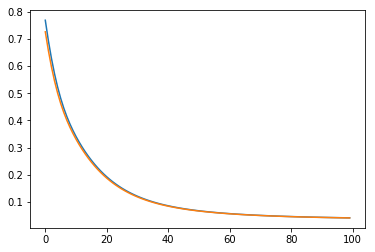

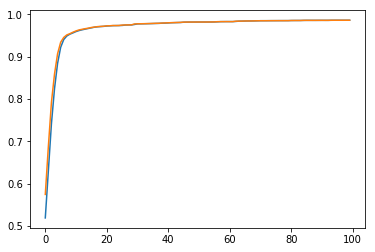

In [ ]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With negatives

In [ ]:
x_train_n, y_train_n = utils.create_dataset(f1.sentences_fr_train, f1, with_negatives=True)
x_train_n.shape, y_train_n.shape

((713276, 37), (713276, 39))

In [ ]:
x_test_n, y_test_n = utils.create_dataset(f1.sentences_fr_dev, f1, with_negatives=True)
x_test_n.shape, y_test_n.shape

((71536, 37), (71536, 39))

In [ ]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='softplus', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = model_n.fit(x_train_n, y_train_n, epochs=100, batch_size=1024, validation_data=(x_test_n, y_test_n), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### Some tests

In [ ]:
for s in sentence:
    print(s)
    x, _ = f1.create_example(s, sentence[int(s[f1.governor_i])])
    prediction = model.predict(x.reshape(1, -1))[0]
    prediction_n = model_n.predict(x.reshape(1, -1))[0]
    
    i2 = np.argmax(prediction[2:])
    label2 = utils.onehot_2_label[i2]
    print('Without negatives :', label2, prediction[i2+2], prediction[:2])

    i = np.argmax(prediction_n[2:])
    label = utils.onehot_2_label[i]
    print('With negatives :', label, prediction_n[i+2], prediction_n[:2], '\n')

#### Eisner's algorithm

Now we have our model, we can use it to create the dependency parsing itself with Eisner's algorithm. 

[Explanatory video](https://youtu.be/du9VQaFEyeA)

In [ ]:
full_left, full_right, part, labels = utils.eisner(sentence, f1, model=model)
full_left_n, full_right_n, part_n, labels_n = utils.eisner(sentence, f1, model=model_n)
true_full_left, true_full_right, true_part, true_labels = utils.eisner(sentence, f1, perfect=True)

#### Decomposition

In [ ]:
sentence_predicted = utils.predict_sentence(sentence, f1, full_left, full_right, part, labels)
pd.DataFrame(sentence_predicted)

In [ ]:
utils.compare(pd.DataFrame(sentence_predicted)[[f1.governor_i, f1.label_i]], pd.DataFrame(sentence)[[f1.governor_i, f1.label_i]])

In [ ]:
sentence_predicted = utils.predict_sentence(sentence, f1, full_left_n, full_right_n, part_n, labels_n)
pd.DataFrame(sentence_predicted)

In [ ]:
utils.compare(pd.DataFrame(sentence_predicted)[[f1.governor_i, f1.label_i]], pd.DataFrame(sentence)[[f1.governor_i, f1.label_i]])

### LAS scores

In [ ]:
sentences_test = utils.predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', f1, model=model)
utils.write_conllu(sentences_test, f1, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test.conll')
utils.score_las('fr_test.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

In [ ]:
sentences_test = utils.predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', f1, model=model_n)
utils.write_conllu(sentences_test, f1, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_n.conll')
utils.score_las('fr_test_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

## F1 English

In [ ]:
sentence = f1.sentences_en_dev[3]
pd.DataFrame(sentence)

### Projectivity

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_en_train, f1)
counter_p, '%.2f %%' % proportion_p

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_en_dev, f1)
counter_p, '%.2f %%' % proportion_p

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_en_test, f1)
counter_p, '%.2f %%' % proportion_p

### Creating Dataset

#### Without Negatives

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_en_train, f1)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_en_dev, f1)
x_test.shape, y_test.shape

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With Negatives

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_en_dev, f1,with_negatives=True)
x_test.shape, y_test.shape

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_en_train, f1,with_negatives=True)
x_train.shape, y_train.shape

In [ ]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model_n.summary()

In [ ]:
h = model_n.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### LAS Score

In [ ]:
sentences_test = utils.predict_sentences("UD_English-LinES/en_lines-ud-test.conllu", f1, model=model)

utils.write_conllu(sentences_test, f1, "UD_English-LinES/en_lines-ud-test.conllu", 'en_test.conll')
utils.score_las('en_test.conll', "UD_English-LinES/en_lines-ud-test.conllu")

In [ ]:
sentences_test = utils.predict_sentences("UD_English-LinES/en_lines-ud-test.conllu", f1, model=model_n)

utils.write_conllu(sentences_test, f1, "UD_English-LinES/en_lines-ud-test.conllu", 'en_test_n.conll')
utils.score_las('en_test_n.conll', "UD_English-LinES/en_lines-ud-test.conllu")

## F1 Dutch

In [ ]:
sentence = f1.sentences_nl_dev[3]
pd.DataFrame(sentence)

### Projectivity

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_nl_train, f1)
counter_p, '%.2f %%' % proportion_p

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_nl_dev, f1)
counter_p, '%.2f %%' % proportion_p

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_nl_test, f1)
counter_p, '%.2f %%' % proportion_p

### Creating Dataset

#### Without Negative 

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_nl_train, f1)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_nl_dev, f1)
x_train.shape, y_train.shape

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With negatives 

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_nl_train, f1,with_negatives=True)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_nl_dev, f1, with_negatives=True)
x_train.shape, y_train.shape

In [ ]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model_n.summary()

In [ ]:
h = model_n.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### LAS Scores

In [ ]:
sentences_test = utils.predict_sentences("UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", f1, model=model)

utils.write_conllu(sentences_test, f1, "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", 'nl_test.conll')
utils.score_las('nl_test.conll', "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu")

In [ ]:
sentences_test = utils.predict_sentences("UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", f1, model=model_n)

utils.write_conllu(sentences_test, f1, "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", 'nl_test_n.conll')
utils.score_las('nl_test_n.conll', "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu")

## F1 Japanese

In [ ]:
sentence = f1.sentences_ja_dev[3]
pd.DataFrame(sentence)

### Projectivity

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_ja_train, f1)
counter_p, '%.2f %%' % proportion_p

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_ja_dev, f1)
counter_p, '%.2f %%' % proportion_p

In [ ]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_ja_test, f1)
counter_p, '%.2f %%' % proportion_p

### Creating Dataset

#### Without Negatives

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_ja_train, f1)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_ja_dev, f1)
x_train.shape, y_train.shape

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With Negatives

In [ ]:
x_train, y_train = utils.create_dataset(f1.sentences_ja_train, f1, with_negatives=True)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f1.sentences_ja_dev, f1, with_negatives=True)
x_train.shape, y_train.shape

In [ ]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model_n.summary()

In [ ]:
h = model_n.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### LAS Score

In [ ]:
sentences_test = utils.predict_sentences("UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", f1, model=model)

utils.write_conllu(sentences_test, f1, "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", 'ja_test.conll')
utils.score_las('ja_test.conll', "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu")

In [ ]:
sentences_test = utils.predict_sentences("UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", f1, model=model_n)

utils.write_conllu(sentences_test, f1, "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", 'ja_test_n.conll')
utils.score_las('ja_test_n.conll', "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu")

## F2 features

In [ ]:
sentence = f2.sentences_fr_train[3]
pd.DataFrame(sentence)

## Morphology Exploration

In [ ]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_fr_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

In [ ]:
inputs_count = 0
for m in morphos:
    inputs_count += len(m)
inputs_count

In [ ]:
morphos

In [ ]:
f2.remove_morpho(['Case', 'Degree'], f2.sentences_fr_train, morphos)

In [ ]:
morphos_vec = f2.morpho_2_vec(morphos)

In [ ]:
print(sentence[3][f2.morpho_i])
f2.convert_morpho(sentence[3], morphos_vec)

## Embeddings

In [ ]:
txts = []
for s in sentence:
    txts.append(list(s.T[lemma_i]))

In [ ]:
word2vec = Word2Vec(txts, size=100, window=5, min_count=1, workers=20, iter=13)

In [ ]:
word2vec.most_similar('homme')

In [ ]:
embeddings = f2.load_embedding_tsv('embeddings/fr.tsv')

In [ ]:
for w, d in f2.most_similar('homme', embeddings):
    print(w, d)

In [ ]:
for w, d in f2.most_similar('femme', embeddings):
    print(w, d)

In [ ]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['homme']))

## Data

In [ ]:
x_train, y_train = utils.create_dataset(f2.sentences_fr_train, f2, morphos_vec, embeddings, mean_embedding, with_negatives=False)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f2.sentences_fr_dev, f2, morphos_vec, embeddings, mean_embedding, with_negatives=False)
x_test.shape, y_test.shape

## Model

In [ ]:
modelf2 = keras.models.Sequential()
modelf2.add(keras.layers.Dense(393, activation='sigmoid', input_dim=793))
modelf2.add(keras.layers.Dense(150, activation='sigmoid'))
modelf2.add(keras.layers.Dense(39, activation='softplus'))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

modelf2.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf2.summary()

In [ ]:
h = modelf2.fit(x_train, y_train, epochs=70, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

## Eisner

In [ ]:
sentences_test = utils.predict_sentences(
    'UD_French-GSD/fr_gsd-ud-test.conllu', 
     f2, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     model=modelf2, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root']
)
utils.write_conllu(sentences_test, f2, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_f2_n.conll')
utils.score_las('fr_test_f2_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

## F3 features

In [ ]:
sentence = f3.sentences_fr_train[3]
pd.DataFrame(sentence)

In [ ]:
x_train, y_train = utils.create_dataset(f3.sentences_fr_train, f3, morphos_vec, embeddings, mean_embedding, False)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f3.sentences_fr_dev, f3, morphos_vec, embeddings, mean_embedding, False)
x_test.shape, y_test.shape

In [ ]:
x1 = keras.layers.Input(shape=(757,))
x = keras.layers.Dense(393, activation='sigmoid')(x1)

y1 = keras.layers.Input(shape=(54,))
y = keras.layers.Reshape((3, -1))(y1)

z1 = keras.layers.Input(shape=(54,))
z = keras.layers.Reshape((3, -1))(z1)
for i in range(1):
    y = keras.layers.LSTM(18,activation='sigmoid',return_sequences=True)(y)
    y = keras.layers.BatchNormalization()(y)
    z = keras.layers.LSTM(18,activation='sigmoid',recurrent_dropout=0.3,return_sequences=True)(z)
    z = keras.layers.BatchNormalization()(z)
y = keras.layers.LSTM(18,activation='sigmoid')(y)
y = keras.layers.BatchNormalization()(y)
z = keras.layers.LSTM(18,activation='sigmoid')(z)
z = keras.layers.BatchNormalization()(z)

x = keras.layers.concatenate([x, y, z])

x = keras.layers.Dense(400, activation='sigmoid')(x)
x = keras.layers.Dense(150, activation='sigmoid')(x)
x = keras.layers.Dense(39, activation='softplus')(x)

modelf3 = keras.models.Model(inputs=[x1, y1, z1], outputs=[x])

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(amsgrad=True,decay=0.001)

modelf3.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf3.summary()

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [ ]:
from keras_tqdm import TQDMNotebookCallback
h = modelf3.fit([x_train[:, :757], x_train[:, 757:811], x_train[:, 811:]], y_train, 
                epochs=45, 
                batch_size=1024, 
                validation_data=([x_test[:, :757], x_test[:, 757:811], x_test[:, 811:]], y_test), 
                verbose=0, 
                callbacks=[tensorboard,TQDMNotebookCallback(leave_inner=False)])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

In [ ]:
sentences_test = utils.predict_sentences(
    'UD_French-GSD/fr_gsd-ud-test.conllu', 
     f3, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     True, 
     model=modelf3, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root'],
     sentences_callback=f3.add_neighbors_pos
)
utils.write_conllu(sentences_test, f3, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_f3_n.conll')
utils.score_las('fr_test_f3_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')